# AOMA on multiple periods of HDF data

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
#from dataloader_halogaland.processer import welch_plot
import os
import koma.oma, koma.plot
import koma.clustering
from time import time

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print((os.listdir("/../../../../../Volumes/LaCie/")))

['.Spotlight-V100', '.fseventsd', 'Warranty.pdf', 'Autorun.inf', 'Start_Here_Win.exe', 'Seagate', '.VolumeIcon.icns', 'Start_Here_Mac.app', '.VolumeIcon.ico', '._.', 'System Volume Information', '$RECYCLE.BIN', '20220513 Pakke ODK', 'Data testkampanje mai 2022 - Master22', 'Nidarosdomen', 'Halogaland_sixth_try.hdf5']


In [3]:
path = '../Data/Halogaland_second_try.hdf5'
analysis_length = 30 #minutes - 10 minutes equals 1200 data points in sampling frequency of 2 Hz
cutoff_frequency = 1 #Hz -> this means sampling frequency becomes 2Hz

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5')

Available accelerometers: ['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']


### Define SSI parameters

In [4]:
i = 100
s = 3
fs = 2
orders = np.arange(2, 100+2, 2)

stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

### Predefining outer loop

In [5]:
number_of_periods = len(loader.periods)
print("Number of perdiods to run " + str(number_of_periods))
freq_modes = []
number_in_sample = 2*60*analysis_length

Number of perdiods to run 88


In [ ]:
for period in range(number_of_periods-10):
    #remove 10 periods and start at the 10th period
    acc = loader.load_all_acceleration_data(loader.periods[period+10], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)

    acc = np.array_split(acc, acc.shape[0]/number_in_sample)
    print(len(acc))

    for j in range(len(acc)):

        t0 = time()

        #Cov-SSI call
        lambd, phi = koma.oma.covssi(acc[j], fs, i, orders, showinfo=False) # find poles by Cov-SSI
        lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

        #Pole clustering
        pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
        prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
        args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

        xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

        #plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

        xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
        fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

        xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
        fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

        freq_modes.append([freq for freq in fn_mean])

        t1 = time()
        print("Time serie " + str(j+1) + " of " + str(number_of_periods) + " done in " + str(t1-t0) + " sec")

16


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


Time serie 1 of 88 done in 63.60862588882446 sec


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


Time serie 2 of 88 done in 63.72148108482361 sec


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


Time serie 3 of 88 done in 65.05219507217407 sec


In [56]:
import itertools
freq_modes_sorted = list(map(list, itertools.zip_longest(*freq_modes, fillvalue=None)))

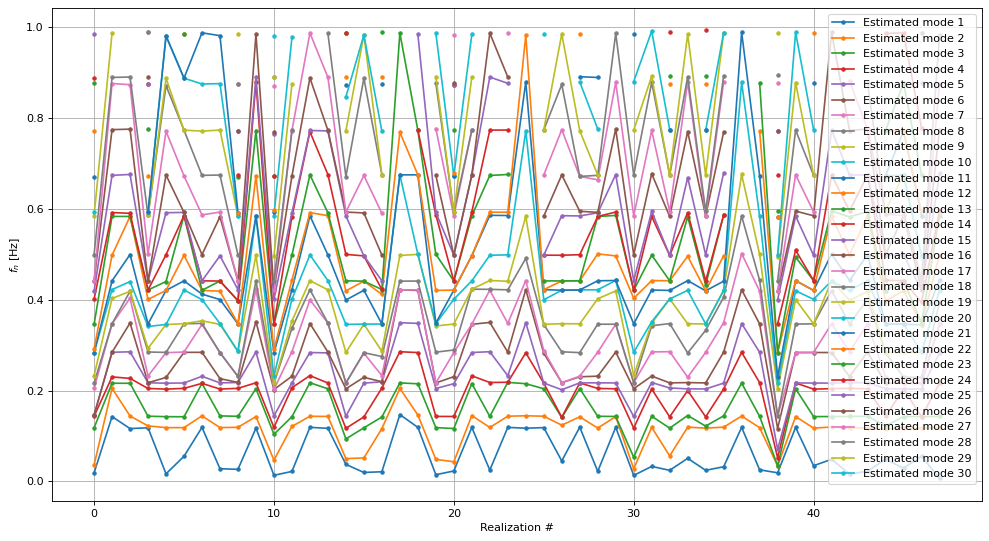

In [57]:
#Plot

plt.figure(figsize=(15, 8), dpi=80)

for i in range(len(freq_modes_sorted)):
    #if (i<len(true_f)):
    #    plt.axhline(y = true_f[i], color = 'r', linestyle = '--', label="True mode " + str(i+1))
    plt.plot(np.arange(0, len(acc)), freq_modes_sorted[i], linestyle="-", marker=".", label="Estimated mode " + str(i+1))

plt.grid()
plt.legend()
plt.xlabel("Realization #")
plt.ylabel("$f_n$ [Hz]")
#plt.savefig("plots/num_example_bad.jpg")
plt.show()